# Hill of Towie Wind Turbine Power Prediction - Exploratory Data Analysis

This notebook contains exploratory data analysis for the wind turbine power prediction competition.

## Goals:
1. Load and examine the training and test datasets
2. Understand the data structure and features
3. Analyze distributions and patterns
4. Identify correlations with target variable
5. Explore temporal patterns if applicable
6. Detect outliers and missing values
7. Plan feature engineering strategies

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Setup plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

# Add src to path for imports
import sys
sys.path.append('../src')

from config import TRAIN_FILE, TEST_FILE, SAMPLE_SUBMISSION_FILE
from utils import load_data, setup_logging

# Setup logging
logger = setup_logging(log_level="INFO")

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading

In [2]:
# Load datasets
print("Loading datasets...")
train_df = load_data(TRAIN_FILE)
test_df = load_data(TEST_FILE)
sample_submission = load_data(SAMPLE_SUBMISSION_FILE)

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Sample submission shape: {sample_submission.shape}")

Loading datasets...


2025-08-29 14:10:27,262 - wind_turbine_prediction - INFO - Loaded data from /home/boujuan/Coding/hill-of-towie-wind-turbine/notebooks/../data/train/training_dataset.parquet - Shape: (210384, 189)
2025-08-29 14:10:27,400 - wind_turbine_prediction - INFO - Loaded data from /home/boujuan/Coding/hill-of-towie-wind-turbine/notebooks/../data/test/submission_dataset.parquet - Shape: (52704, 159)
2025-08-29 14:10:27,424 - wind_turbine_prediction - INFO - Loaded data from /home/boujuan/Coding/hill-of-towie-wind-turbine/notebooks/../data/raw/sample_model_submission.csv - Shape: (52704, 2)


Training data shape: (210384, 189)
Test data shape: (52704, 159)
Sample submission shape: (52704, 2)


## 2. Data Overview

In [3]:
# Basic info about training data
print("=== TRAINING DATA INFO ===")
print(train_df.info())
print("\n=== FIRST FEW ROWS ===")
display(train_df.head())

=== TRAINING DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210384 entries, 0 to 210383
Columns: 189 entries, TimeStamp_StartFormat to target
dtypes: bool(1), datetime64[us, UTC](1), float32(11), float64(169), int16(6), int32(1)
memory usage: 285.1 MB
None

=== FIRST FEW ROWS ===


,TimeStamp_StartFormat,wtc_AcWindSp_mean;1,wtc_AcWindSp_mean;2,wtc_AcWindSp_mean;3,wtc_AcWindSp_mean;4,wtc_AcWindSp_mean;5,wtc_AcWindSp_mean;7,wtc_AcWindSp_min;1,wtc_AcWindSp_min;2,wtc_AcWindSp_min;3,...,ERA5_surface_pressure,ERA5_cloud_cover,ERA5_wind_speed_10m,ERA5_wind_speed_100m,ERA5_wind_direction_10m,ERA5_wind_direction_100m,ERA5_wind_gusts_10m,id,is_valid,target
0,2016-01-01 00:00:00+00:00,6.085917,5.830675,6.613091,6.998510,7.645727,7.040790,2.0,1.1,1.6,...,976.166321,0.0,6.080296,10.040418,233.695404,236.784729,13.0,-210384,True,352.522308
1,2016-01-01 00:10:00+00:00,5.824693,5.810768,5.895642,6.521900,6.413868,6.599652,2.1,2.2,1.9,...,982.179504,100.0,3.301515,6.958448,178.264328,187.431320,6.9,-210383,True,294.078888
2,2016-01-01 00:20:00+00:00,7.100180,6.386981,7.606015,7.695034,7.812548,7.469052,2.2,2.1,0.0,...,985.240540,78.0,3.478505,4.648656,198.435043,198.824799,7.7,-210382,True,587.302795
3,2016-01-01 00:30:00+00:00,8.232280,7.787337,7.808475,9.624884,9.727865,8.529939,3.2,2.6,2.1,...,983.532532,82.0,3.400000,6.774216,180.000000,188.488861,6.4,-210381,True,881.533325
4,2016-01-01 00:40:00+00:00,9.534926,8.607587,9.268380,10.105590,9.908615,9.968257,4.6,2.7,5.2,...,976.718750,99.0,3.006659,4.401136,356.186005,358.698059,9.2,-210380,True,1299.646973


In [4]:
# Basic info about test data
print("=== TEST DATA INFO ===")
print(test_df.info())
print("\n=== FIRST FEW ROWS ===")
display(test_df.head())

=== TEST DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52704 entries, 0 to 52703
Columns: 159 entries, TimeStamp_StartFormat to is_valid
dtypes: bool(1), datetime64[us, UTC](1), float32(11), float64(140), int16(5), int32(1)
memory usage: 59.7 MB
None

=== FIRST FEW ROWS ===


,TimeStamp_StartFormat,wtc_AcWindSp_mean;2,wtc_AcWindSp_mean;3,wtc_AcWindSp_mean;4,wtc_AcWindSp_mean;5,wtc_AcWindSp_mean;7,wtc_AcWindSp_min;2,wtc_AcWindSp_min;3,wtc_AcWindSp_min;4,wtc_AcWindSp_min;5,...,ERA5_precipitation,ERA5_surface_pressure,ERA5_cloud_cover,ERA5_wind_speed_10m,ERA5_wind_speed_100m,ERA5_wind_direction_10m,ERA5_wind_direction_100m,ERA5_wind_gusts_10m,id,is_valid
0,2020-01-01 00:00:00+00:00,11.16164,10.88820,11.86938,11.86918,11.67452,8.30,7.78,9.75,9.13,...,0.0,994.515015,18.0,4.808326,9.484725,224.999893,227.563812,9.7,0,True
1,2020-01-01 00:10:00+00:00,11.30721,10.86559,12.97147,12.50372,11.38912,7.88,6.94,10.07,9.44,...,0.0,1000.559082,95.0,2.785677,5.247857,201.037582,210.963684,4.4,1,True
2,2020-01-01 00:20:00+00:00,11.27332,10.89379,12.21393,12.14904,11.12704,8.50,6.94,9.65,9.96,...,0.0,989.992554,68.0,5.803448,9.226592,271.974884,274.350983,11.1,2,True
3,2020-01-01 00:30:00+00:00,10.46305,10.40827,12.34099,11.54505,11.38056,7.78,6.53,9.23,8.50,...,0.0,996.174988,55.0,4.701064,9.276314,218.088821,221.941223,8.8,3,True
4,2020-01-01 00:40:00+00:00,9.50840,11.04761,12.36365,10.43871,11.75062,6.74,7.57,9.44,7.98,...,0.0,996.174988,55.0,4.701064,9.276314,218.088821,221.941223,8.8,4,True


In [5]:
# Sample submission format
print("=== SAMPLE SUBMISSION ===")
display(sample_submission.head())
print(f"Submission columns: {sample_submission.columns.tolist()}")

=== SAMPLE SUBMISSION ===


,id,prediction
0,0,1790.092578
1,1,1883.399609
2,2,1777.343188
3,3,1671.691602
4,4,1612.906592


Submission columns: ['id', 'prediction']


## 3. Statistical Summary

In [6]:
# Statistical summary of numerical features
print("=== TRAINING DATA STATISTICS ===")
display(train_df.describe())

print("\n=== TEST DATA STATISTICS ===")
display(test_df.describe())

=== TRAINING DATA STATISTICS ===


,wtc_AcWindSp_mean;1,wtc_AcWindSp_mean;2,wtc_AcWindSp_mean;3,wtc_AcWindSp_mean;4,wtc_AcWindSp_mean;5,wtc_AcWindSp_mean;7,wtc_AcWindSp_min;1,wtc_AcWindSp_min;2,wtc_AcWindSp_min;3,wtc_AcWindSp_min;4,...,ERA5_precipitation,ERA5_surface_pressure,ERA5_cloud_cover,ERA5_wind_speed_10m,ERA5_wind_speed_100m,ERA5_wind_direction_10m,ERA5_wind_direction_100m,ERA5_wind_gusts_10m,id,target
count,207924.000000,208602.000000,208761.000000,208709.000000,208900.000000,209112.000000,207924.000000,208602.000000,208761.000000,208709.000000,...,210383.000000,210383.000000,210383.000000,210383.000000,210383.000000,210383.000000,210383.000000,210383.000000,210384.000000,207924.000000
mean,6.809166,6.299143,6.936793,6.893935,6.648201,7.413250,3.257146,2.735207,3.216013,3.348669,...,0.099924,981.255615,73.041771,4.283358,6.954129,203.702499,207.424133,9.115131,-105192.500000,644.150917
std,3.661185,3.441122,3.725423,3.756014,3.555637,3.936492,2.415248,2.207898,2.427035,2.548706,...,0.279436,12.238345,30.997932,2.083709,3.211799,81.902351,82.332748,4.191503,60732.773854,713.702650
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,935.289612,0.000000,0.000000,0.000000,0.707312,0.572935,1.000000,-210384.000000,0.000000
25%,4.183936,3.808565,4.296395,4.219467,4.105589,4.607768,1.300000,0.800000,1.220000,1.300000,...,0.000000,973.811768,51.000000,2.687006,4.622770,149.858704,153.749817,5.900000,-157788.250000,71.367268
50%,6.395520,5.893241,6.489745,6.420088,6.217504,6.922301,3.100000,2.500000,3.000000,3.100000,...,0.000000,982.341919,88.000000,4.101220,6.789698,217.568665,223.531265,8.600000,-105192.500000,342.880646
75%,8.945873,8.312780,9.089612,9.012848,8.681343,9.739011,4.700000,4.100000,4.650000,4.800000,...,0.000000,989.877869,100.000000,5.643580,9.019978,261.027466,264.699158,11.800000,-52596.750000,1044.126526
max,24.242889,25.819929,25.289280,29.797590,27.843321,26.827499,17.400000,16.900000,18.500000,18.900000,...,4.100000,1013.855225,100.000000,13.118689,20.500975,360.000000,360.000000,31.200001,-1.000000,2304.946045



=== TEST DATA STATISTICS ===


,wtc_AcWindSp_mean;2,wtc_AcWindSp_mean;3,wtc_AcWindSp_mean;4,wtc_AcWindSp_mean;5,wtc_AcWindSp_mean;7,wtc_AcWindSp_min;2,wtc_AcWindSp_min;3,wtc_AcWindSp_min;4,wtc_AcWindSp_min;5,wtc_AcWindSp_min;7,...,ERA5_dew_point_2m,ERA5_precipitation,ERA5_surface_pressure,ERA5_cloud_cover,ERA5_wind_speed_10m,ERA5_wind_speed_100m,ERA5_wind_direction_10m,ERA5_wind_direction_100m,ERA5_wind_gusts_10m,id
count,52604.000000,52337.000000,52653.000000,52319.000000,52379.000000,52604.000000,52337.000000,52653.000000,52319.000000,52379.000000,...,52704.000000,52704.000000,52704.000000,52704.000000,52704.000000,52704.000000,52704.000000,52704.000000,52704.000000,52704.000000
mean,6.467132,7.149636,7.082702,6.846784,7.701422,2.908622,3.412405,3.520994,3.336621,4.053139,...,4.836185,0.100545,979.411987,73.067207,4.367349,7.074431,203.573318,206.471893,9.295228,26351.500000
std,3.483106,3.738228,3.829718,3.651836,4.005026,2.130995,2.293802,2.492803,2.443242,2.705957,...,4.465186,0.291298,14.623009,32.288101,2.161277,3.402216,82.605446,83.186066,4.364356,15214.478631
min,0.065016,0.108080,0.110956,0.165631,0.101959,0.000000,0.000000,0.000000,0.000000,0.000000,...,-8.458000,0.000000,922.872375,0.000000,0.100000,0.100000,0.753839,0.550901,1.100000,0.000000
25%,3.843298,4.379602,4.198860,4.081433,4.713226,1.060000,1.630000,1.550000,1.310000,2.040000,...,1.442000,0.000000,968.940857,53.000000,2.692582,4.429447,154.798904,158.838669,5.900000,13175.750000
50%,6.005620,6.699629,6.526880,6.343047,7.244526,2.690000,3.260000,3.260000,3.100000,3.830000,...,4.592000,0.000000,981.719482,89.000000,4.123106,6.902898,216.430954,221.583313,8.800000,26351.500000
75%,8.534835,9.413929,9.349536,9.027143,10.178875,4.240000,4.730000,4.890000,4.650000,5.590000,...,7.992000,0.000000,989.717163,100.000000,5.768882,9.305912,258.111359,260.837738,12.000000,39527.250000
max,27.119869,25.689920,23.758150,23.090340,24.861839,18.320000,17.370001,16.740000,15.800000,19.469999,...,16.542000,4.000000,1017.618835,100.000000,12.886039,20.080338,360.000000,360.000000,28.600000,52703.000000


## 4. Missing Values Analysis

In [7]:
# Check for missing values
print("=== MISSING VALUES IN TRAINING DATA ===")
train_missing = train_df.isnull().sum()
train_missing_pct = 100 * train_missing / len(train_df)
missing_df = pd.DataFrame({
    'Column': train_missing.index,
    'Missing Count': train_missing.values,
    'Missing %': train_missing_pct.values
}).sort_values('Missing Count', ascending=False)
display(missing_df[missing_df['Missing Count'] > 0])

print("\n=== MISSING VALUES IN TEST DATA ===")
test_missing = test_df.isnull().sum()
test_missing_pct = 100 * test_missing / len(test_df)
missing_test_df = pd.DataFrame({
    'Column': test_missing.index,
    'Missing Count': test_missing.values,
    'Missing %': test_missing_pct.values
}).sort_values('Missing Count', ascending=False)
display(missing_test_df[missing_test_df['Missing Count'] > 0])

=== MISSING VALUES IN TRAINING DATA ===


,Column,Missing Count,Missing %
1,wtc_AcWindSp_mean;1,2460,1.169290
7,wtc_AcWindSp_min;1,2460,1.169290
13,wtc_AcWindSp_max;1,2460,1.169290
19,wtc_AcWindSp_stddev;1,2460,1.169290
109,wtc_PitcPosA_stddev;1,2460,1.169290
...,...,...,...
183,ERA5_wind_direction_10m,1,0.000475
182,ERA5_wind_speed_100m,1,0.000475
181,ERA5_wind_speed_10m,1,0.000475
180,ERA5_cloud_cover,1,0.000475



=== MISSING VALUES IN TEST DATA ===


,Column,Missing Count,Missing %
4,wtc_AcWindSp_mean;5,385,0.730495
14,wtc_AcWindSp_max;5,385,0.730495
9,wtc_AcWindSp_min;5,385,0.730495
24,wtc_ScYawPos_mean;5,385,0.730495
29,wtc_ScYawPos_min;5,385,0.730495
...,...,...,...
133,wtc_ActPower_stddev;4,51,0.096767
118,wtc_ActPower_mean;4,51,0.096767
113,wtc_ScReToOp_timeon;4,51,0.096767
128,wtc_ActPower_max;4,51,0.096767


## 5. Target Variable Analysis

In [8]:
# Identify target column (assuming it's the last column or has 'power' in name)
potential_targets = [col for col in train_df.columns if 'power' in col.lower()]
if not potential_targets:
    # If no column with 'power', assume last numerical column is target
    numerical_cols = train_df.select_dtypes(include=[np.number]).columns
    target_col = numerical_cols[-1]
else:
    target_col = potential_targets[0]

print(f"Assumed target column: {target_col}")

if target_col in train_df.columns:
    target = train_df[target_col]
    
    print(f"Target statistics:")
    print(f"  Mean: {target.mean():.2f}")
    print(f"  Std: {target.std():.2f}")
    print(f"  Min: {target.min():.2f}")
    print(f"  Max: {target.max():.2f}")
    print(f"  Median: {target.median():.2f}")
else:
    print("Could not identify target column. Please update manually.")

Assumed target column: wtc_PowerRef_endvalue;1
Target statistics:
  Mean: 2284.29
  Std: 181.37
  Min: 0.00
  Max: 2300.00
  Median: 2300.00


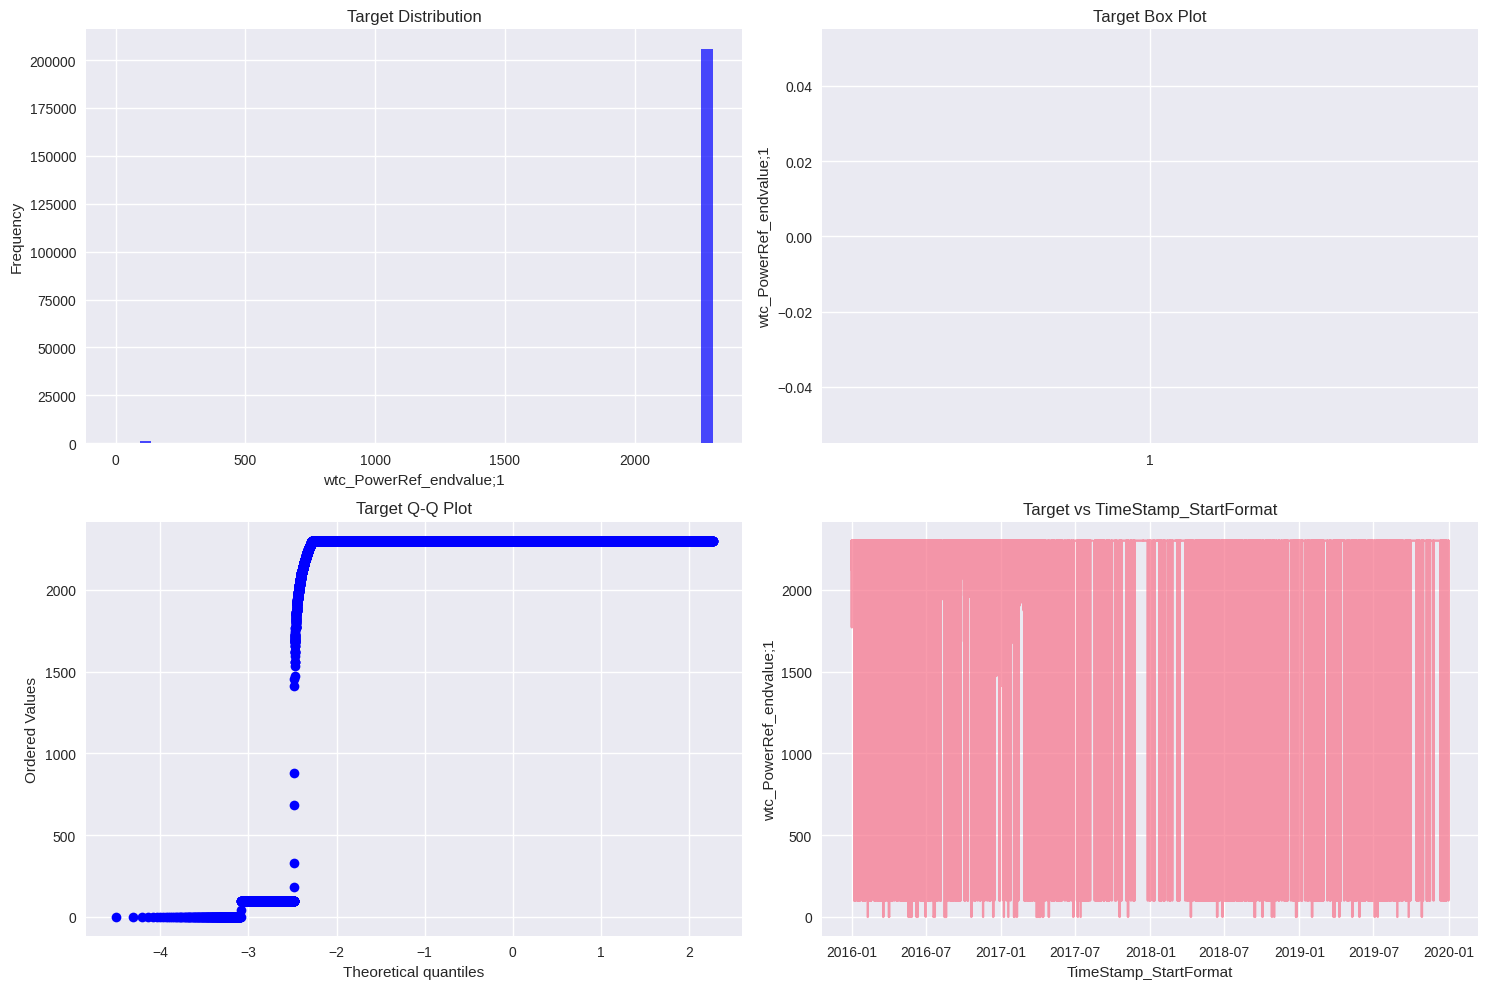

In [9]:
# Target distribution visualization
if target_col in train_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Histogram
    axes[0, 0].hist(target, bins=50, alpha=0.7, color='blue')
    axes[0, 0].set_title('Target Distribution')
    axes[0, 0].set_xlabel(target_col)
    axes[0, 0].set_ylabel('Frequency')
    
    # Box plot
    axes[0, 1].boxplot(target)
    axes[0, 1].set_title('Target Box Plot')
    axes[0, 1].set_ylabel(target_col)
    
    # QQ plot
    from scipy import stats
    stats.probplot(target, dist="norm", plot=axes[1, 0])
    axes[1, 0].set_title('Target Q-Q Plot')
    
    # Time series plot (if we can identify a time column)
    time_cols = [col for col in train_df.columns if any(word in col.lower() for word in ['time', 'date', 'timestamp'])]
    if time_cols:
        time_col = time_cols[0]
        if pd.api.types.is_datetime64_any_dtype(train_df[time_col]) or train_df[time_col].dtype == 'object':
            try:
                time_data = pd.to_datetime(train_df[time_col])
                axes[1, 1].plot(time_data, target, alpha=0.7)
                axes[1, 1].set_title(f'Target vs {time_col}')
                axes[1, 1].set_xlabel(time_col)
                axes[1, 1].set_ylabel(target_col)
            except:
                axes[1, 1].scatter(range(len(target)), target, alpha=0.5)
                axes[1, 1].set_title('Target vs Index')
        else:
            axes[1, 1].scatter(range(len(target)), target, alpha=0.5)
            axes[1, 1].set_title('Target vs Index')
    else:
        axes[1, 1].scatter(range(len(target)), target, alpha=0.5)
        axes[1, 1].set_title('Target vs Index')
    
    plt.tight_layout()
    plt.show()

## 6. Feature Analysis

In [10]:
# Analyze numerical features
numerical_features = train_df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numerical_features:
    numerical_features.remove(target_col)

print(f"Numerical features ({len(numerical_features)}): {numerical_features[:10]}...")

# Categorical features
categorical_features = train_df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

Numerical features (186): ['wtc_AcWindSp_mean;1', 'wtc_AcWindSp_mean;2', 'wtc_AcWindSp_mean;3', 'wtc_AcWindSp_mean;4', 'wtc_AcWindSp_mean;5', 'wtc_AcWindSp_mean;7', 'wtc_AcWindSp_min;1', 'wtc_AcWindSp_min;2', 'wtc_AcWindSp_min;3', 'wtc_AcWindSp_min;4']...
Categorical features (0): []


Top 10 features correlated with target:


,Correlation
wtc_PowerRef_endvalue;3,0.176617
wtc_PowerRef_endvalue;7,0.175865
wtc_PowerRef_endvalue;4,0.165210
wtc_PowerRef_endvalue;2,0.156480
wtc_PowerRef_endvalue;5,0.152737
wtc_ScReToOp_timeon;1,0.087971
wtc_PitcPosA_max;1,-0.087123
wtc_GenRpm_mean;7,0.081883
wtc_GenRpm_min;7,0.079545
wtc_GenRpm_min;1,0.079036


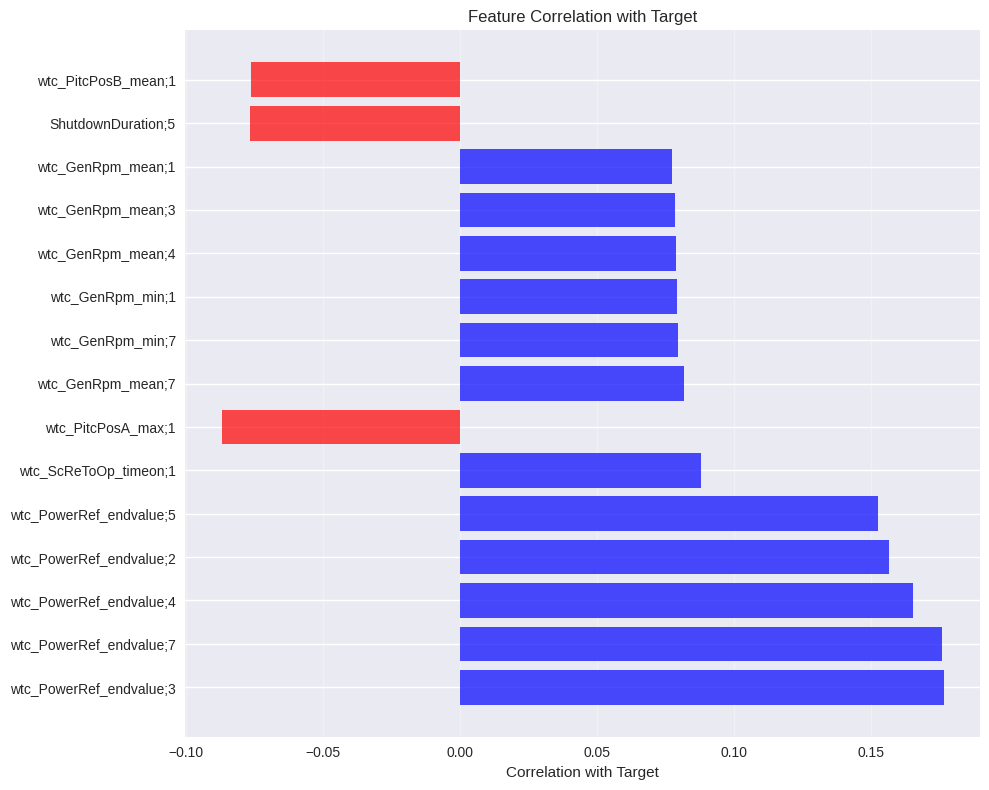

In [11]:
# Correlation analysis with target
if target_col in train_df.columns and len(numerical_features) > 0:
    correlations = train_df[numerical_features + [target_col]].corr()[target_col].sort_values(key=abs, ascending=False)
    correlations = correlations.drop(target_col)  # Remove self-correlation
    
    print("Top 10 features correlated with target:")
    display(correlations.head(10).to_frame('Correlation'))
    
    # Plot correlations
    plt.figure(figsize=(10, 8))
    top_corr = correlations.head(15)
    colors = ['red' if x < 0 else 'blue' for x in top_corr.values]
    plt.barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7)
    plt.yticks(range(len(top_corr)), top_corr.index)
    plt.xlabel('Correlation with Target')
    plt.title('Feature Correlation with Target')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## 7. Feature Distributions

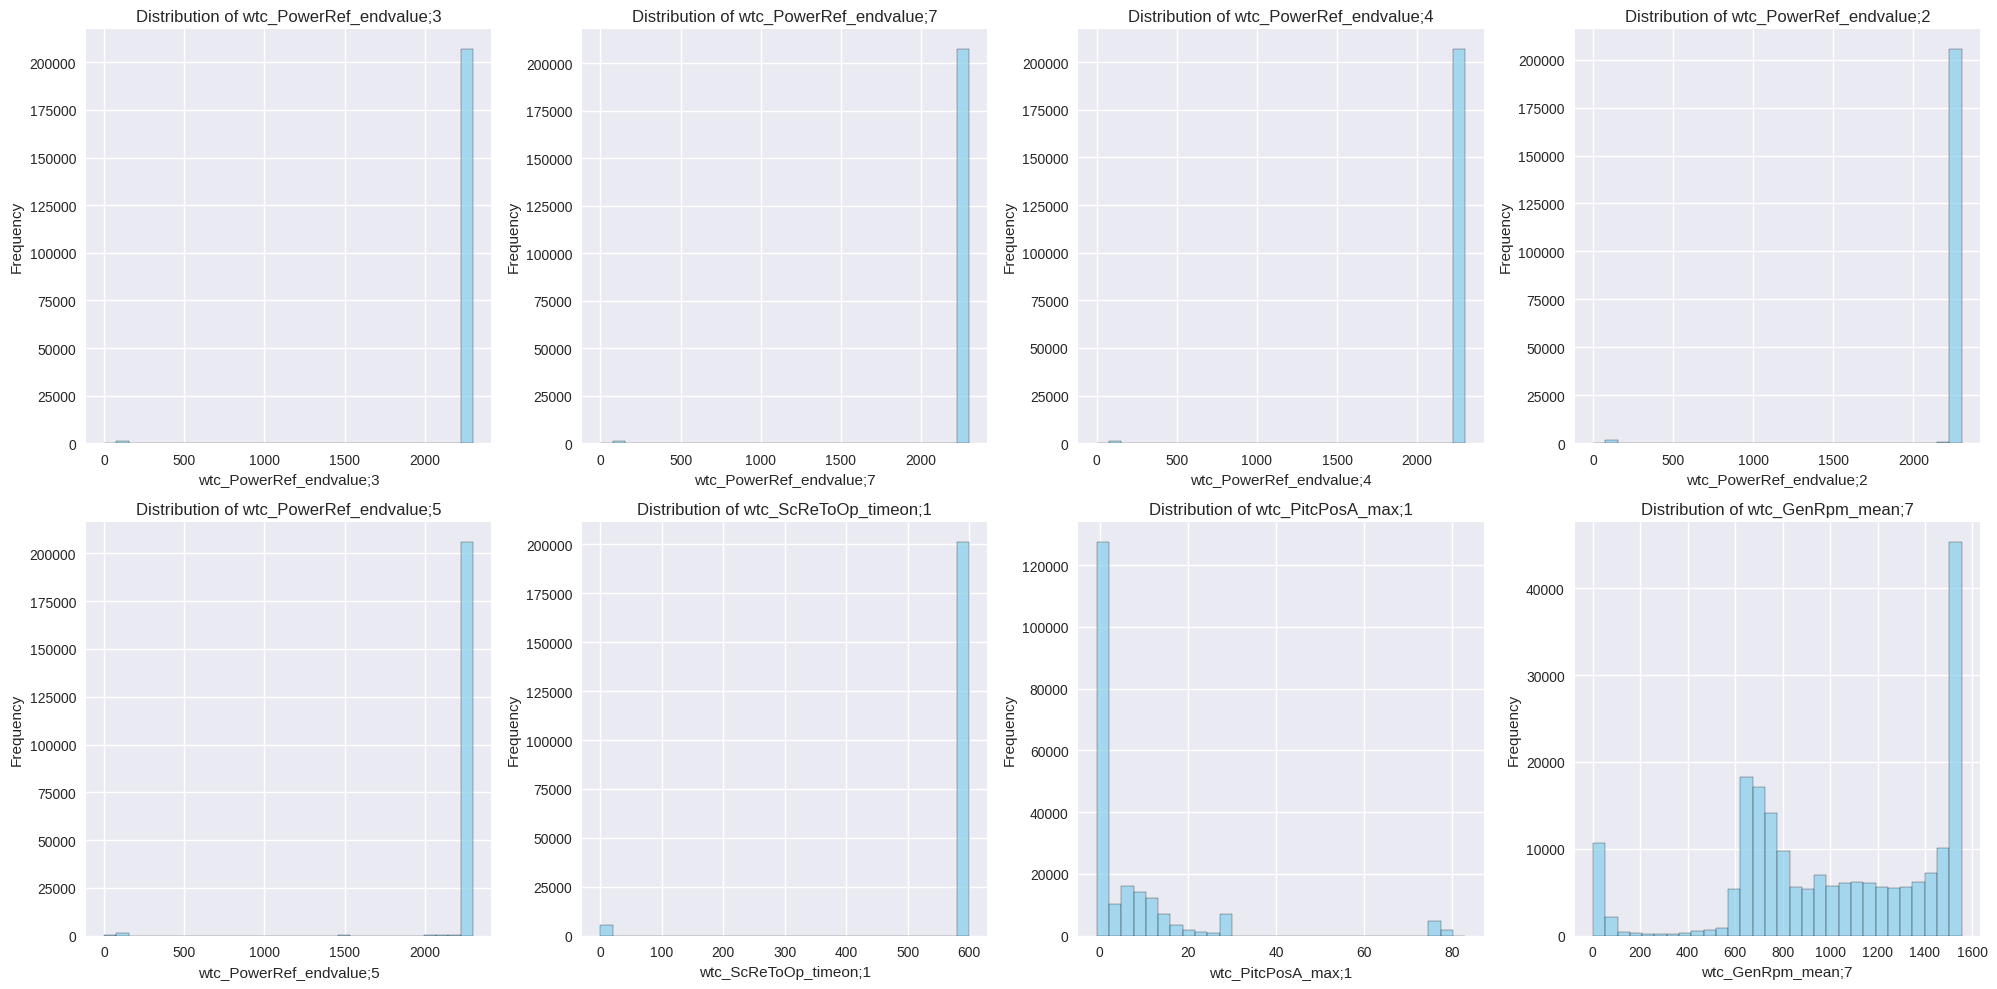

In [12]:
# Plot distributions of top correlated features
if target_col in train_df.columns and len(numerical_features) > 0:
    top_features = correlations.head(8).index.tolist()
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.ravel()
    
    for i, feature in enumerate(top_features):
        if feature in train_df.columns:
            axes[i].hist(train_df[feature], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
            axes[i].set_title(f'Distribution of {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()

## 8. Correlation Matrix

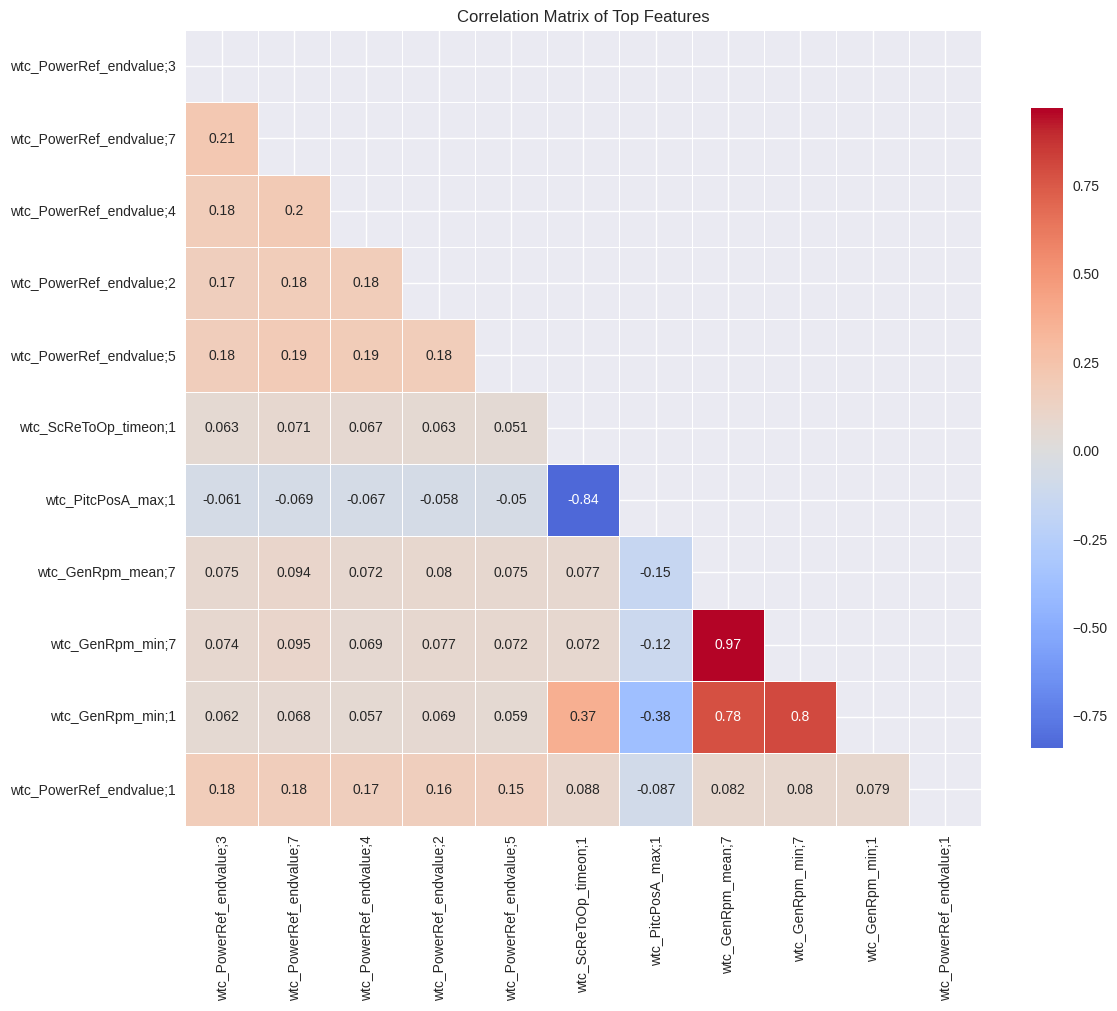

In [13]:
# Correlation matrix of top features
if target_col in train_df.columns and len(numerical_features) > 0:
    top_features = correlations.head(10).index.tolist() + [target_col]
    correlation_matrix = train_df[top_features].corr()
    
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": .8})
    plt.title('Correlation Matrix of Top Features')
    plt.tight_layout()
    plt.show()

## 9. Outlier Detection

In [14]:
# Detect outliers using IQR method for top features
if len(numerical_features) > 0:
    top_features_for_outliers = correlations.head(5).index.tolist()
    
    outlier_summary = []
    
    for feature in top_features_for_outliers:
        if feature in train_df.columns:
            Q1 = train_df[feature].quantile(0.25)
            Q3 = train_df[feature].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = train_df[(train_df[feature] < lower_bound) | (train_df[feature] > upper_bound)]
            outlier_count = len(outliers)
            outlier_pct = 100 * outlier_count / len(train_df)
            
            outlier_summary.append({
                'Feature': feature,
                'Outlier Count': outlier_count,
                'Outlier %': outlier_pct,
                'Lower Bound': lower_bound,
                'Upper Bound': upper_bound
            })
    
    outlier_df = pd.DataFrame(outlier_summary)
    print("Outlier Analysis:")
    display(outlier_df)

Outlier Analysis:


,Feature,Outlier Count,Outlier %,Lower Bound,Upper Bound
0,wtc_PowerRef_endvalue;3,1991,0.946365,2300.0,2300.0
1,wtc_PowerRef_endvalue;7,1841,0.875067,2300.0,2300.0
2,wtc_PowerRef_endvalue;4,2053,0.975835,2300.0,2300.0
3,wtc_PowerRef_endvalue;2,3595,1.708780,2300.0,2300.0
4,wtc_PowerRef_endvalue;5,3209,1.525306,2300.0,2300.0


## 10. Temporal Analysis (if applicable)

Analyzing temporal patterns using column: TimeStamp_StartFormat


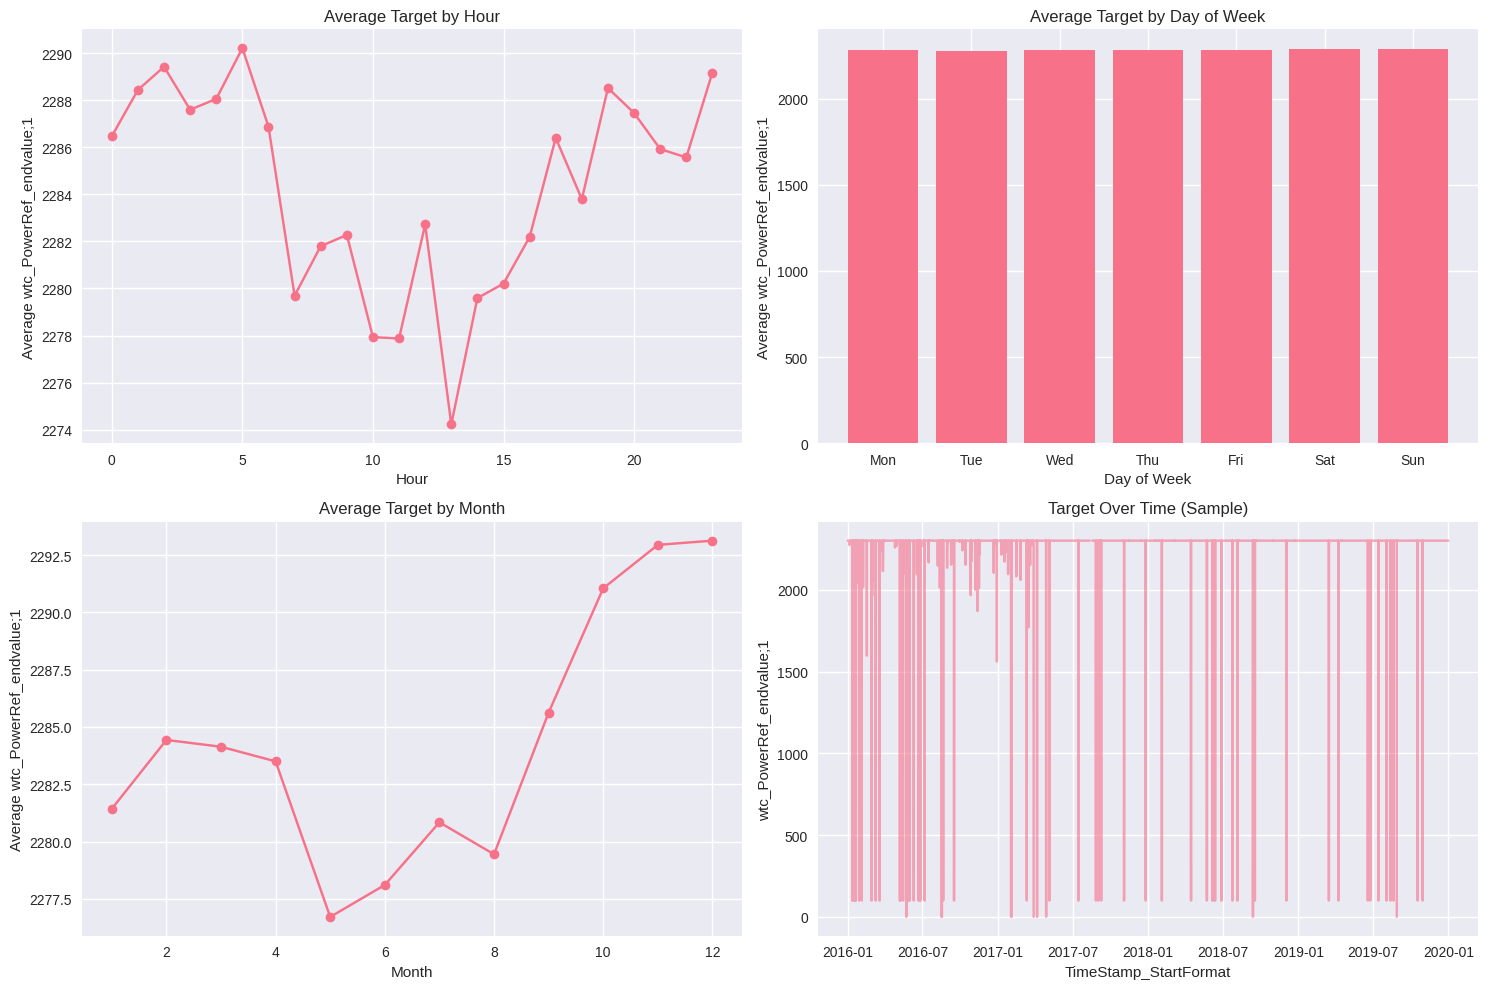

In [15]:
# Time series analysis if we have datetime columns
time_cols = [col for col in train_df.columns if any(word in col.lower() for word in ['time', 'date', 'timestamp'])]

if time_cols and target_col in train_df.columns:
    time_col = time_cols[0]
    print(f"Analyzing temporal patterns using column: {time_col}")
    
    try:
        # Convert to datetime
        train_df_temp = train_df.copy()
        train_df_temp[time_col] = pd.to_datetime(train_df_temp[time_col])
        
        # Extract time features
        train_df_temp['hour'] = train_df_temp[time_col].dt.hour
        train_df_temp['day_of_week'] = train_df_temp[time_col].dt.dayofweek
        train_df_temp['month'] = train_df_temp[time_col].dt.month
        
        # Plot temporal patterns
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Hourly pattern
        hourly_avg = train_df_temp.groupby('hour')[target_col].mean()
        axes[0, 0].plot(hourly_avg.index, hourly_avg.values, marker='o')
        axes[0, 0].set_title('Average Target by Hour')
        axes[0, 0].set_xlabel('Hour')
        axes[0, 0].set_ylabel(f'Average {target_col}')
        
        # Daily pattern
        daily_avg = train_df_temp.groupby('day_of_week')[target_col].mean()
        day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        axes[0, 1].bar(range(7), daily_avg.values)
        axes[0, 1].set_title('Average Target by Day of Week')
        axes[0, 1].set_xlabel('Day of Week')
        axes[0, 1].set_ylabel(f'Average {target_col}')
        axes[0, 1].set_xticks(range(7))
        axes[0, 1].set_xticklabels(day_names)
        
        # Monthly pattern
        monthly_avg = train_df_temp.groupby('month')[target_col].mean()
        axes[1, 0].plot(monthly_avg.index, monthly_avg.values, marker='o')
        axes[1, 0].set_title('Average Target by Month')
        axes[1, 0].set_xlabel('Month')
        axes[1, 0].set_ylabel(f'Average {target_col}')
        
        # Time series plot (sampled if too many points)
        if len(train_df_temp) > 10000:
            sample_df = train_df_temp.sample(10000).sort_values(time_col)
        else:
            sample_df = train_df_temp.sort_values(time_col)
        
        axes[1, 1].plot(sample_df[time_col], sample_df[target_col], alpha=0.6)
        axes[1, 1].set_title('Target Over Time (Sample)')
        axes[1, 1].set_xlabel(time_col)
        axes[1, 1].set_ylabel(target_col)
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not perform temporal analysis: {e}")
else:
    print("No datetime columns found for temporal analysis")

## 11. Train vs Test Distribution Comparison

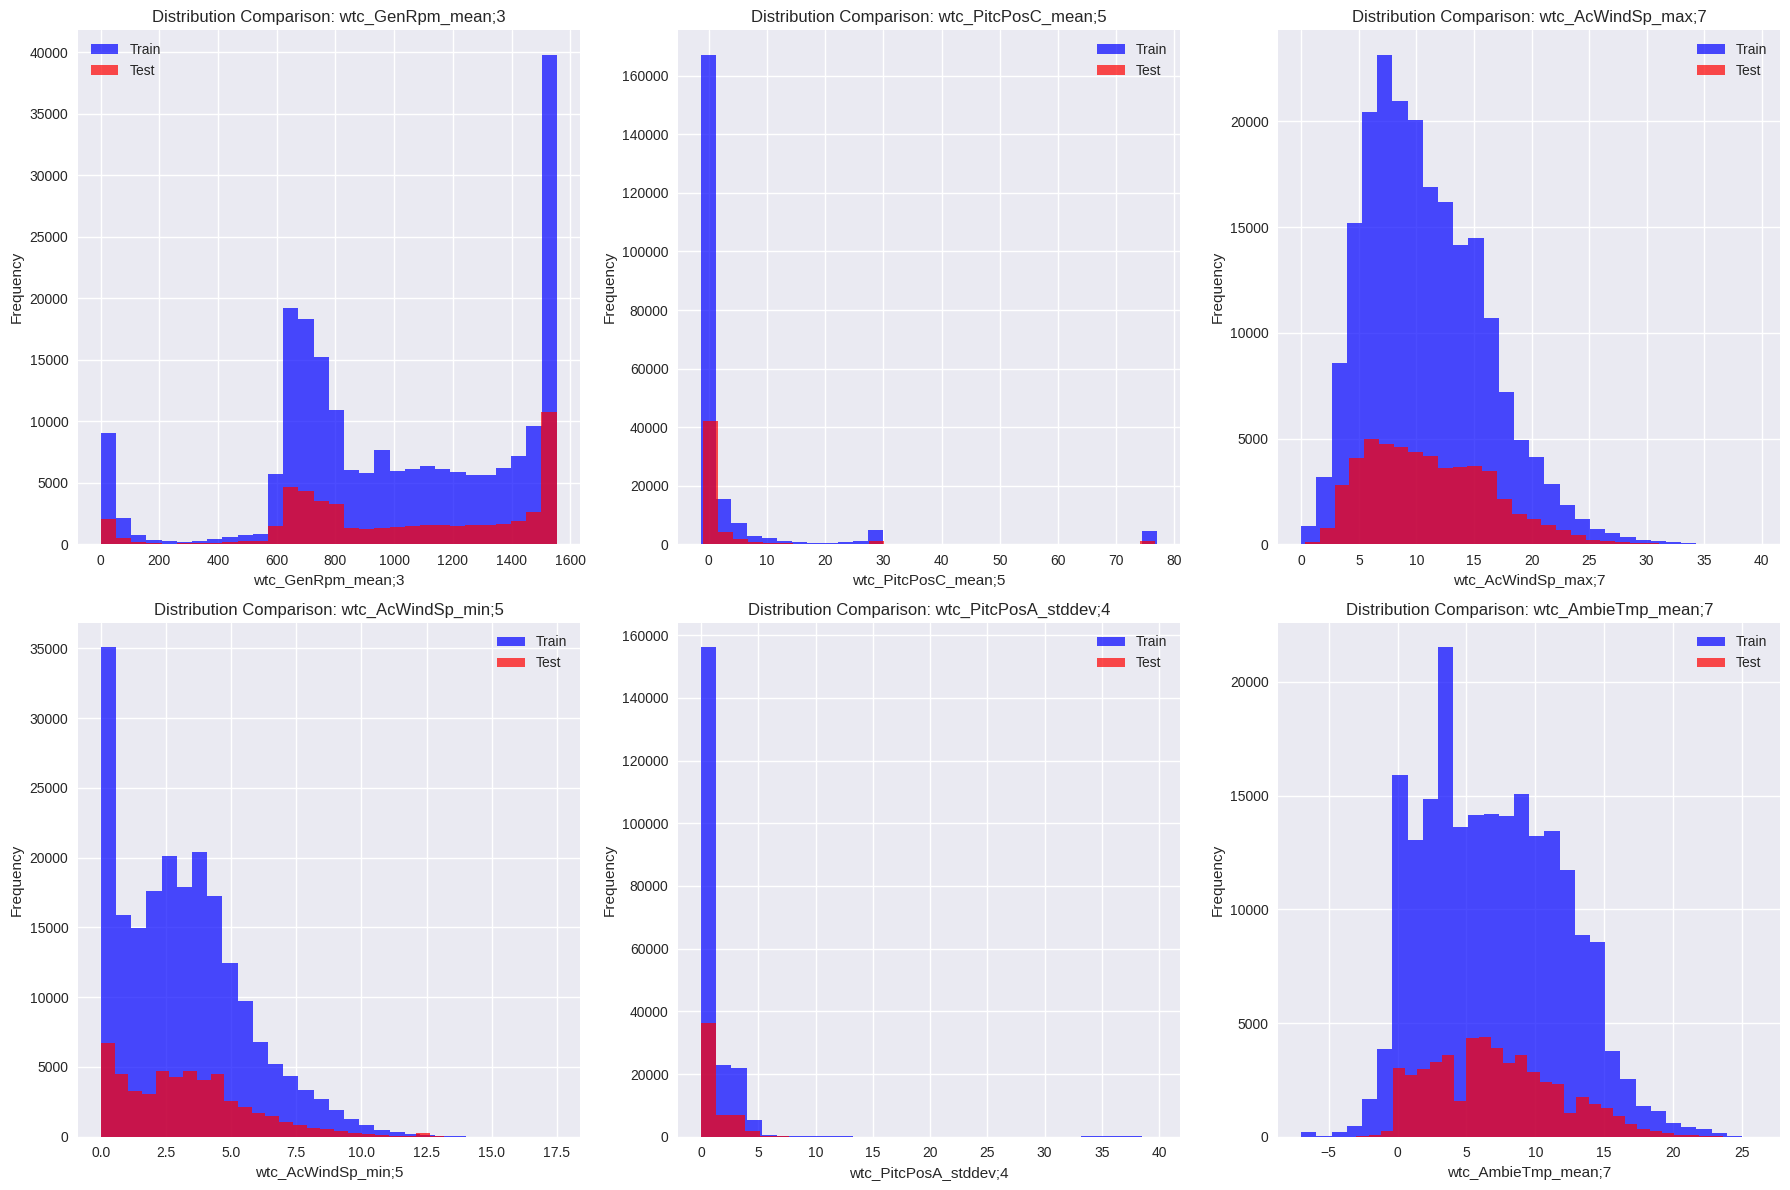

In [16]:
# Compare feature distributions between train and test
common_features = list(set(train_df.columns) & set(test_df.columns))
common_numerical = [col for col in common_features if train_df[col].dtype in ['int64', 'float64']]

if len(common_numerical) > 0:
    # Plot distributions for top features
    top_common_features = common_numerical[:6]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.ravel()
    
    for i, feature in enumerate(top_common_features):
        if feature in train_df.columns and feature in test_df.columns:
            axes[i].hist(train_df[feature], bins=30, alpha=0.7, label='Train', color='blue')
            axes[i].hist(test_df[feature], bins=30, alpha=0.7, label='Test', color='red')
            axes[i].set_title(f'Distribution Comparison: {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Frequency')
            axes[i].legend()
    
    plt.tight_layout()
    plt.show()

## 12. Key Insights and Next Steps

In [17]:
# Summary of findings
print("=== KEY INSIGHTS FROM EDA ===")
print(f"1. Dataset shape - Train: {train_df.shape}, Test: {test_df.shape}")
print(f"2. Target column identified: {target_col if 'target_col' in locals() else 'Not identified'}")
print(f"3. Number of numerical features: {len(numerical_features)}")
print(f"4. Number of categorical features: {len(categorical_features)}")
print(f"5. Missing values present: {train_df.isnull().sum().sum() > 0}")
print(f"6. Temporal features available: {len(time_cols) > 0 if 'time_cols' in locals() else False}")

if 'correlations' in locals():
    print(f"7. Top correlated feature: {correlations.index[0]} (correlation: {correlations.iloc[0]:.3f})")

print("\n=== RECOMMENDED NEXT STEPS ===")
print("1. Feature Engineering:")
print("   - Create lag features if temporal data available")
print("   - Generate polynomial/interaction features for top correlated features")
print("   - Create statistical features (rolling means, std, etc.)")
print("   - Handle categorical variables with encoding")
print("\n2. Data Preprocessing:")
print("   - Handle missing values appropriately")
print("   - Consider outlier treatment")
print("   - Scale/normalize features if needed")
print("\n3. Model Development:")
print("   - Start with simple baseline models")
print("   - Try ensemble methods (XGBoost, LightGBM, CatBoost)")
print("   - Implement cross-validation strategy")
print("   - Consider neural networks for complex patterns")
print("\n4. Validation Strategy:")
print("   - Time-based splits if temporal data")
print("   - Stratified splits for stable validation")
print("   - Monitor overfitting carefully")

=== KEY INSIGHTS FROM EDA ===
1. Dataset shape - Train: (210384, 189), Test: (52704, 159)
2. Target column identified: wtc_PowerRef_endvalue;1
3. Number of numerical features: 186
4. Number of categorical features: 0
5. Missing values present: True
6. Temporal features available: True
7. Top correlated feature: wtc_PowerRef_endvalue;3 (correlation: 0.177)

=== RECOMMENDED NEXT STEPS ===
1. Feature Engineering:
   - Create lag features if temporal data available
   - Generate polynomial/interaction features for top correlated features
   - Create statistical features (rolling means, std, etc.)
   - Handle categorical variables with encoding

2. Data Preprocessing:
   - Handle missing values appropriately
   - Consider outlier treatment
   - Scale/normalize features if needed

3. Model Development:
   - Start with simple baseline models
   - Try ensemble methods (XGBoost, LightGBM, CatBoost)
   - Implement cross-validation strategy
   - Consider neural networks for complex patterns

4. V

## 13. Save Processed Data (Optional)

In [ ]:
# Optionally save cleaned/processed versions of the data
# This cell can be uncommented and modified based on findings

# from utils import save_data
# from config import PROCESSED_DATA_DIR

# # Save processed training data
# save_data(train_df, PROCESSED_DATA_DIR / "train_processed.parquet")
# save_data(test_df, PROCESSED_DATA_DIR / "test_processed.parquet")

# print("Processed data saved successfully!")